In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import pickle

In [7]:
class Svm:
    def __init__(self, points, labels, kernel, param):
        self.points = points.copy()
        self.labels = labels.copy()
        self.kernel_name = kernel
        self.param = param # kernel parameters
        self.select_kernel(kernel, param)
        self.alphas = np.zeros(shape=len(labels))
        self.b = 0 # intercept
        self.unbound_alpha_count = 0
    
    def select_kernel(self, kernel, param):
        if (kernel == 'rbf'):
            self.kernel = self.rbf_kernel
        elif (kernel == 'poly'):
            self.kernel = self.poly_kernel
        else:
            self.kernel = self.lin_kernel
    
    # do prediction by using matrix multiplication?
    
    def poly_kernel(self, a, b):
        return (np.dot(a, b) + self.param[0]) ** self.param[1]
    
    def rbf_kernel(self, a, b):
        dif = (a-b)
        return np.exp(- self.param[0] * np.linalg.norm(dif))
    
    def lin_kernel(self, a, b):
        return np.dot(a,b)

    # Removes labels, points and alpha when corresponding alpha = 0
    def filter_out_useless(self):
        points = []
        labels = []
        alphas = []
        for i in range(0, len(self.labels)):
            if (self.alphas[i] != 0):
                points.append(self.points[i])
                labels.append(self.labels[i])
                alphas.append(self.alphas[i])
        self.points = points
        self.labels = labels
        self.alphas = alphas
    
    # return w*x - b
    def classifier(self, x):
        return sum(map(lambda p, alpha, y: alpha * y * self.kernel(x, p), self.points, self.alphas, self.labels)) - self.b
    
    def point_pred(self, x):
        return sum(map(lambda p, alpha, y: 1 if (alpha * y * self.kernel(x, p)) else -1, self.points, self.alphas, self.labels)) - self.b
    
    def predict(self, X):
        return list(map(self.classifier, X))

    def classif(self, x):
        if (x > 0):
            return 1
        else:
            return -1

    def accuracy(self, pred, r_vals):
        acc = 0
        for i in range(0, len(pred)):
            if (classif(pred[i]) == r_vals[i]):
                acc += 1
        return acc / len(pred)
    
    # loads svm model that was saved by save_model()
    def load_model(self, path):
        f = open(path, "rb")
        tmp = pickle.load(f)
        self.points = tmp[0]
        self.labels = tmp[1]
        self.alphas = tmp[2]
        self.b = tmp[3]
        self.kernel_name = tmp[4]
        self.param = tmp[5]
        self.select_kernel(self.kernel_name, self.param)
    
    # pickle save model
    def save_model(self, path):
        tmp = np.array([self.points, self.labels, self.alphas, self.b, self.kernel_name, self.param])
        f = open(path, "wb")
        pickle.dump(tmp, f)
    
    def get_saved(self):
        return self.save_points, self.save_labels, self.save_alphas, self.save_b
    
    # Run smo to optimize alphas
    # save iterations is the list of number of iterations that smo saves current points, labels, alpha, b
    def fit(self, max_passes, tol=0.0001, C=1.0, save_iterations=[]):
        smo = Smo(self.points, self.labels, self.kernel_name, self.param)
        self.alphas, self.b = smo.run(max_passes, tol, C, save_iterations)
            
        if (save_iterations != []):
            self.save_alphas = smo.save_alphas
            self.save_points = smo.save_points
            self.save_labels = smo.save_labels
            self.save_b = smo.save_b
        print("before filtering", len(self.labels))
        self.filter_out_useless()
        print("after filtering", len(self.labels))
        #print(self.alphas)

In [8]:


#@jitclass(smo_spec)
class Smo:
    def __init__(self, points, labels, kernel, param):
        self.points = points
        self.labels = labels
        self.alphas = np.zeros(shape=len(labels))
        self.b = 0.0
        self.C = 1.0
        self.select_kernel(kernel, param)
        self.param = param
        self.error_cache = np.zeros(shape=len(labels))
        self.eps = 0.001
        self.kernel_matrix = np.zeros(shape=(len(labels), len(labels)))
        self.in_cache = np.zeros(shape=len(labels)) # in_cache[i] == 1 iff alpha is in alpha_cache
        self.alpha_cache = np.zeros(shape=len(labels)) # stores unbound alphas
        self.unbound_count = 0
        self.save_alphas = []
        self.save_points = []
        self.save_labels = []
        self.save_b = []
    
    def select_kernel(self, kernel, param):
        if (kernel == 'rbf'):
            self.kernel = self.rbf_kernel
        elif (kernel == 'poly'):
            self.kernel = self.poly_kernel
        else:
            self.kernel = self.lin_kernel
    
    def poly_kernel(self, a, b):
        return (np.dot(a, b) + self.param[0]) ** self.param[1]
        #return (np.dot(a, b) + 1.0) ** 3.0
    
    def rbf_kernel(self, a, b):
        dif = (a-b)
        return np.exp(- self.param[0] * np.linalg.norm(dif))
    
    def lin_kernel(self, a, b):
        return np.dot(a,b)
    
    # objective funtion
    def obj_function(self, i, j, a_j):
        a_i = self.alphas[i]
        ao_j = self.alphas[j]
        b = self.b
        y_i = self.labels[i]
        y_j = self.labels[j]
        s = y_i * y_j
        gamma = a_i + s * ao_j
        par = gamma - s * a_j
        K_ii = self.kernel_value(i, i)
        K_ij = self.kernel_value(i, j)
        K_jj = self.kernel_value(j, j)
        v_i = self.classifier_train(i) + b - y_i*a_i*K_ii - y_j*ao_j*K_ij
        v_j = self.classifier_train(j) + b - y_i*a_i*K_ij - y_j*ao_j*K_jj
        W = par + a_j - K_ii*par*par/2 - K_jj*a_j*a_j/2 - s*K_ij*par*a_j - y_i*par*v_i - y_j*a_j*v_j
        return W
        alphas = np.sum(self.alphas)
        double_sum = 0.0
        for i in range(0, len(self.labels)):
            for j in range(0, len(self.labels)):
                double_sum += self.labels[i] * self.labels[j] * self.alphas[i] * self.alphas[j] * self.kernel_value(i, j)
        return alphas - (double_sum / 2)
    
    # w*points[j] - b computed using dual representation and kernel matrix cache
    def classifier_train(self, j):
        tmp = 0.0
        for i in range(0, len(self.labels)):
            tmp += self.alphas[i] * self.labels[i] * self.kernel_value(i, j)
        return tmp - self.b
    
    # compute upper and lower bounds that indicate how much alpha_j can change
    def bounds(self, alpha_i, y_i, alpha_j, y_j, C):
        #print(alpha_i, alpha_j)
        if (y_i != y_j):
            return max(0, alpha_j - alpha_i), min(C, C + alpha_j - alpha_i)
        return max(0, alpha_i + alpha_j - C), min(C, alpha_i + alpha_j)
    
    # Update b value using two optimized alphas
    def b_threshold(self, alpha_i, alpha_i_old, y_i, er_i,\
                    alpha_j, alpha_j_old, y_j, er_j, C, k_ij, k_ii, k_jj):
        alpha_i_diff = alpha_i - alpha_i_old
        alpha_j_diff = alpha_j - alpha_j_old
        b1 = self.b + er_i + y_i * alpha_i_diff * k_ii + y_j * alpha_j_diff * k_ij
        if (0 < alpha_i and alpha_i < C):
            return b1
        b2 = self.b + er_j + y_i * alpha_i_diff * k_ij + y_j * alpha_j_diff * k_jj
        if (0 < alpha_j and alpha_j < C):
            return b2
        return (b1 + b2) * 0.5
        
    # Check that alpha_i break KKT conditions
    def check_kkt_conditions(self, alpha_i, y_i, er_i, tol, C):
        r = y_i * er_i
        tmp = (r < -tol) and (alpha_i < C)
        return tmp or ((r > tol) and (alpha_i > 0))
    
    # Check alpha[i] break KKT cond. and try to find alpha_j
    def examine_example(self, i, tol, C):
        er_i = self.error_cache[i] if (self.is_unbound(self.alphas[i])) else self.error(i)
        if (self.check_kkt_conditions(self.alphas[i], self.labels[i], er_i, tol, C)):
            j = self.select_best_unbound_cache(i, er_i)
            res = 0
            if (j != -1):
                res = self.take_step(i, j, er_i)
                if (res == 1):
                    return res
            if (self.try_any_unbound_cache(i, er_i) == 1):
                return 1
            if (self.try_any_alpha(i, er_i) == 1):
                return 1
        return 0
         
    # Selects best candidate from alpha_j and optimize
    def select_best_unbound(self, i, er_i):
        maximum = 0
        index = -1
        count = 0
        for j in range(0, len(self.labels)):
            if (i != j and self.is_unbound(self.alphas[j])):
                #print("select best unbound j alpha: ", j, self.alphas[j])
                diff = np.abs(er_i - self.error_cache[j])
                count += 1
                if (diff >= maximum):
                    maximum = diff
                    index = j
        #if (count > 30):
            #print(count)
        return index
    
    # Selects best candidate from alpha_j using cache and optimize
    def select_best_unbound_cache(self, i, er_i):
        maximum = 0
        index = -1
        count = 0
        for j in range(0, self.unbound_count):
            ind_j = int(self.alpha_cache[j])
            if (i != ind_j and self.is_unbound(self.alphas[ind_j])):
                diff = np.abs(er_i - self.error_cache[ind_j])
                count += 1
                if (diff >= maximum):
                    maximum = diff
                    index = ind_j
        return index
    
    #Tries to select any alpha as alpha_j and optimize
    def try_any_alpha(self, i, er_i):
        start = np.random.randint(0, len(self.labels))
        for j in range(start, len(self.labels)):
            if (i != j):
                if (self.take_step(i, j, er_i) == 1):
                    return 1
        for j in range(0, start):
            if (i != j):
                if (self.take_step(i, j, er_i) == 1):
                    return 1
        return 0
    
    # Try to select any unbound alpha using cache as alpha_j and optimize
    def try_any_unbound_cache(self, i, er_i):
        start = 0
        if (self.unbound_count != 0):
            start = np.random.randint(0, self.unbound_count)
        for j in range(0, self.unbound_count):
            index = int(self.alpha_cache[(start + j) % self.unbound_count])
            if (i != index and self.is_unbound(self.alphas[index])):
                if (self.take_step(i, index, er_i) == 1):
                    return 1
        return 0
    
    # Try to select any unbound alpha using cache as alpha_j and optimize
    def try_any_unbound(self, i, er_i):
        start = np.random.randint(0, len(self.labels))
        for j in range(start, len(self.labels)):
            if (i != j and self.is_unbound(self.alphas[j])):
                #print("select any unbound j alpha: ", j, self.alphas[j])
                if (self.take_step(i, j, er_i) == 1):
                    return 1
        for j in range(0, start):
            if (i != j and self.is_unbound(self.alphas[j])):
                #print("select any unbound j alpha: ", j, self.alphas[j])
                if (self.take_step(i, j, er_i) == 1):
                    return 1
        return 0

    # select alpha_j randomly -> not used
    def select_latter(self, i, er_i):
        # add better heuristic
        j = np.random.randint(0, len(self.labels))
        while(i == j):
            j = np.random.randint(0, len(self.labels))
            print("Looping rnd")
        return j    
            
    def try_bound(self, alpha, const):
        if (alpha < const):
            return 0
        elif alpha > (self.C - const):
            return self.C
        return alpha
        
    # Compute values for Lobj, Hobj when eta is not negative 
    def bounds_obj_no_opt(self, i, j, L, H):
        alpha_j = self.alphas[j]
        self.alphas[j] = L
        Lobj = self.obj_function(i, j, L)
        self.alphas[j] = H
        Hobj = self.obj_function(i, j, H)
        self.alphas[j] = alpha_j
        return Lobj, Hobj
    
    # Compute values for Lobj, Hobj when eta is not negative 
    def bounds_obj(self, eta, L, H, y_j, er_i, er_j, alpha_j):
        c1 = eta / 2.0
        c2 = y_j * (er_i - er_j) - eta * alpha_j
        Lobj = c1 * L * L + c2 * L
        Hobj = c1 * H * H + c2 * H
        return Lobj, Hobj    
    
    # Returns K(points[i], points[j]) from cache. if not in cache then compute it, save in cache and ret
    def kernel_value(self, i, j):
        ker_val = self.kernel_matrix[i, j] 
        if (ker_val != 0):
            return ker_val 
        ker_val = self.kernel(self.points[i], self.points[j])
        self.kernel_matrix[i, j] = ker_val
        self.kernel_matrix[j, i] = ker_val
        return ker_val
    
    #Try to optimize alpha[i], alpha[j]                    
    def take_step(self, i, j, er_i):
        y_i, y_j = self.labels[i], self.labels[j]
        x_i, x_j = self.points[i], self.points[j]
        alpha_i, alpha_j = self.alphas[i], self.alphas[j]
        er_j = self.error_cache[j] if (self.is_unbound(alpha_j)) else self.error(j)
        alpha_i_old, alpha_j_old = alpha_i, alpha_j
        
        # compute L,H - bounds for new possible alpha values
        L, H = self.bounds(alpha_i, y_i, alpha_j, y_j, self.C)
        if (L == H):
            return 0
        
        # precalculate kernel values
        k_ij = self.kernel_value(i, j)
        k_ii = self.kernel_value(i, i)
        k_jj = self.kernel_value(j, j)
        
        eta = 2 * k_ij - k_ii - k_jj #self.opt_par_eta(x_i, x_j)
        if (eta < 0):
            alpha_j = alpha_j - y_j * (er_i - er_j) / eta
            alpha_j = self.clip(alpha_j, L, H)
        else:
            #Lobj, Hobj = self.bounds_obj(eta, L, H, y_j, er_i, er_j, alpha_j)
            Lobj, Hobj = self.bounds_obj_no_opt(i, j, L, H)
            if Lobj > (Hobj + self.eps):
                alpha_j = L
            elif Lobj < (Hobj - self.eps):
                alpha_j = H
       
        alpha_j = self.try_bound(alpha_j, 1e-8)
       
        if (np.abs(alpha_j - alpha_j_old) < self.eps * (alpha_j + alpha_j_old + self.eps)): 
            return 0
        
        
        alpha_i = alpha_i + y_i * y_j * (alpha_j_old - alpha_j)
        if (alpha_i < 0):
            alpha_j += y_i * y_j * alpha_i
            alpha_i = 0
        elif (alpha_i > self.C):
            alpha_j += y_i*y_j * (alpha_i - self.C)
            alpha_i = self.C
            
        #this actually break kkt cond
        #alpha_i = self.try_bound(alpha_i, 1e-8)
      
        # write new alphas to memory
        self.alphas[i] = alpha_i
        self.alphas[j] = alpha_j
        
        # calc new threshold value
        new_b = self.b_threshold(alpha_i, alpha_i_old, y_i, er_i,
                    alpha_j, alpha_j_old, y_j, er_j, self.C, k_ij, k_ii, k_jj)
        self.update_unbound_cache(i, j, alpha_i, alpha_j)
        self.update_errors(i, alpha_i - alpha_i_old, j, alpha_j - alpha_j_old, self.b - new_b)
        self.b = new_b
        return 1
    
    # Clear in_cache of not unbound alphas -> set 0
    # Clear alpha_chache of not unbound alphas
    def clear_unbound_cache(self):
        tmp = np.zeros(shape=len(self.labels))
        count = 0
        for i in range(0, self.unbound_count):
            index = int(self.alpha_cache[i])
            if self.is_unbound(self.alphas[index]):
                tmp[i] = index
                if (self.in_cache[index] == 0):
                    print("ERRORROROOROOROROROOROORO in_chace wrong value!!!")
                count += 1
            else:
                self.in_cache[index] = 0
        self.unbound_count = count
        self.alpha_cache = tmp
                         
    # Updates alpha_cache, in_cache using two optimized alpha_i, alpha_j
    def update_unbound_cache(self, i, j, alpha_i, alpha_j):
        if (self.in_cache[i] == 0 and self.is_unbound(alpha_i)):
            self.alpha_cache[self.unbound_count] = i
            self.in_cache[i] = 1
            self.unbound_count += 1
        
        if (self.in_cache[j] == 0 and self.is_unbound(alpha_j)):
            self.alpha_cache[self.unbound_count] = j
            self.in_cache[j] = 1
            self.unbound_count += 1
    
    # Update error cache using alpha_i, alpha_j
    def update_errors(self, i, alpha_i_diff, j, alpha_j_diff, b_diff):
        tmp_i = self.labels[i] * alpha_i_diff
        tmp_j = self.labels[j] * alpha_j_diff
        x_i, x_j = self.points[i], self.points[j]
        for k in range(0, self.unbound_count):
            index = int(self.alpha_cache[k])
            if (self.is_unbound(self.alphas[index])):
                self.error_cache[index] += tmp_i * self.kernel_value(i, index) + tmp_j * self.kernel_value(j, index) + b_diff
        
        self.error_cache[i] = 0
        self.error_cache[j] = 0
                
    def clip(self, alpha, L, H):
        if (alpha > H):
            return H
        if (alpha < L):
            return L
        return alpha # L <= alpha <= H
        
    def opt_par_eta(self, x_i, x_j):
        return 2 * self.kernel(x_i, x_j) - self.kernel(x_i, x_i) - self.kernel(x_j, x_j)
        
    def is_unbound(self, alpha):
        return alpha != 0 and alpha != self.C 
    
    def stats(self):
        zeros = 0
        ones = 0
        for alph in self.alphas:
            if (alph == 1):
                ones+=1
            elif (alph == 0):
                zeros+=1
        print("ones, zeros, all", ones, zeros, len(self.alphas))
        
    # Try to save model when save_iterations[i] == current iteration count
    def save_current_alphas(self, save_iterations, count):
        for i in range(0, len(save_iterations)):
            if (save_iterations[i] == count):
                self.save_alphas.append(self.alphas.copy())
                self.save_points.append(self.points.copy())
                self.save_labels.append(self.labels.copy())
                self.save_b.append(self.b.copy())
    
    # Run the SMO optimization
    # Terminates after max_passes or convergence
    def run(self, max_passes, tol, C, save_iterations=[]):
        print("SMO running")
        examine_all = 1
        
        self.C = C
        tmp = 0
        num_changed_alphas = 0
        while (num_changed_alphas > 0) or (examine_all == 1):
            num_changed_alphas = 0
            if (examine_all == 1):
                for i in range(0, len(self.labels)):
                    num_changed_alphas += self.examine_example(i, tol, C)
                    tmp += 1
                    if(max_passes < tmp):
                        return self.alphas, self.b
                    if (tmp % (len(self.labels) * 2) == 0):
                        self.clear_unbound_cache()
                    if (tmp % 20000 == 0):
                        print("optimization count all", tmp)
                        #self.stats()
                    if save_iterations != []:
                        self.save_current_alphas(save_iterations, tmp)
            
            else:
                for i in range(0, self.unbound_count):
                    index = int(self.alpha_cache[i])
                    if (self.is_unbound(self.alphas[index])):
                        num_changed_alphas += self.examine_example(index, tol, C)
                        tmp +=1
                        if(max_passes < tmp):
                            return self.alphas, self.b
                        if (tmp % (len(self.labels) * 2) == 0):
                            self.clear_unbound_cache()
                        if (tmp % 20000 == 0):
                            #elf.stats()
                            print("optimization count UNBOUND", tmp)
                        if save_iterations != []:
                            self.save_current_alphas(save_iterations, tmp)
            
            if (examine_all == 1):
                examine_all = 0
            elif (num_changed_alphas == 0):
                examine_all = 1
        return self.alphas, self.b
    
    def error(self, index):
        return self.classifier_train(index) - self.labels[index]

In [9]:
# Separate points for each class and ret
def split(points, labels, dim):
    results = [[],[]]
    for i in range(0, len(labels)):
        if (np.random.rand() > 0.0):
            val = labels[i]
            if (val == -1):
                val = 0
            else:
                val = 1
            results[val].append(points[i])
    return results

# Read data containing points and labels
def read_data(path):
    data = np.load(path)
    labels = data.T[-1]
    data = np.delete(data.T, -1, 0)
    
    return data.T, labels

# Make instances +1, -1 for svm. class target_class_value is +1, all else -1
def binary_labels(target_class_value, labels):
    return np.array(list(map(lambda l: 1 if (l == target_class_value) else - 1, labels)))

def filt(x, l, t1, t2):
    if (l == t1) or (l == t2):
        return x
    return None

# Take instances of t1, t2 classes and prep them for svm (-1, +1)
def two_class_binary_labels(t1, t2, data, labels):
    l_new = list(filter(lambda l: l == t1 or l == t2, labels))
    tmp = []
    for i in range(0, len(data)):
        if ((labels[i] == t1) or (labels[i] == t2)):
            tmp.append(data[i])
    return np.array(tmp), binary_labels(t1, l_new)

# Train one vs all svm model & measure accuracy on the train set
def svm_one_vs_rest(x_train, y_train, t, kernel, param, iterations=20000, C_par=1.0, tolerance=0.001, save_iter=[]):
    data, labels = x_train, binary_labels(t, y_train)
    print(kernel, param)
    svm = Svm(data, labels, kernel, param)
    svm.fit(iterations, C=C_par, tol=tolerance, save_iterations=save_iter)
    pred = svm.predict(data)
    print("train set accuracy", svm.accuracy(pred, labels))
    return svm

def validation_set(x_train, y_train, size_ratio):
    x_val, y_val = bootstrap(size_ratio * len(x_train), x_train, y_test)

def bootstrap(size, x_train, y_train):
    idx = np.random.choice(len(y_train), size)
    return x_train[idx], y_train[idx]

# split data into two to create simple train and validation set
def simple_val_set(data, labels):
    msk = np.random.rand(len(labels)) < 0.7

    x_train , y_train = data[msk], labels[msk]
    x_val, y_val  = data[~msk], labels[~msk]
    return x_train, y_train, x_val, y_val
    
# Reduce instances number of each class so that one-vs-all svm has two classes with about the same size
def fix_imbalanced_dataset(split_data, chosen_class):
    reduced_x_train, labels_counts = reduce_classes(split_data)
    data, labels = merge(reduced_x_train, labels_counts, chosen_class)
    data = np.concatenate((data, split_data[chosen_class]))
    labels = np.concatenate((labels, np.full(len(split_data[chosen_class]), chosen_class)))
    shuffle_in_unison(data, labels)
    return data, labels

# Compute accuracy for given agruments
def saved_accuracy(orig_points, orig_labels, points, labels, alphas, b, svm, x_val, y_val):
    svm.points = points
    svm.labels = labels
    svm.alphas = alphas
    svm.b = b
    svm.filter_out_useless()
    return svm.accuracy(svm.predict(orig_points), orig_labels), svm.accuracy(svm.predict(x_val), y_val)

# Train multiple models and compute accuracies on train and validation set.
# Prints accuracy for each save_iter[i] for each model
# also saved results in a file
def find_param(x_train_whole, y_train_whole):
    save_iter =  [500, 1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000] 
    iterations = 50000
    for classi in range(0, 4):
        x_train, y_train, x_val, y_val = simple_val_set(x_train_whole, y_train_whole)
        split_data = split_to_class_arrays(x_train, y_train, [0, 1, 2, 3, 4])
        data, labels = fix_imbalanced_dataset(split_data, classi)
        print(labels)
        x_val, y_val = x_val, binary_labels(classi, y_val)
        data, labels = data, binary_labels(classi, labels)
        
        eval_param(data, labels, x_val, y_val, classi, 'lin', [], save_iter, iterations, "models/lin"+str(classi)+"-1_3.txt")
        eval_param(data, labels, x_val, y_val, classi, 'poly', [1.0, 3.0], save_iter, iterations, "models/poly"+str(classi)+"-1_3.txt")
        eval_param(data, labels, x_val, y_val, classi, 'rbf', [1.0], save_iter, iterations, "models/rbf"+str(classi)+"-1.txt")
        eval_param(data, labels, x_val, y_val, classi, 'poly', [0.0, 3.0], save_iter, iterations, "models/poly"+str(classi)+"-0_3.txt")
        eval_param(data, labels, x_val, y_val, classi, 'poly', [1.0, 2.0], save_iter, iterations, "models/poly"+str(classi)+"-1_2.txt")
        eval_param(data, labels, x_val, y_val, classi, 'poly', [0.0, 2.0], save_iter, iterations, "models/poly"+str(classi)+"-0_2.txt")
        eval_param(data, labels, x_val, y_val, classi, 'poly', [0.0, 5.0], save_iter, iterations, "models/poly"+str(classi)+"-0_5.txt")
        eval_param(data, labels, x_val, y_val, classi, 'poly', [5.0, 2.0], save_iter, iterations, "models/poly"+str(classi)+"-5_2.txt")
        eval_param(data, labels, x_val, y_val, classi, 'rbf', [2.0], save_iter, iterations, "models/rbf"+str(classi)+"-2.txt")
        eval_param(data, labels, x_val, y_val, classi, 'rbf', [0.5], save_iter, iterations, "models/rbf"+str(classi)+"-0p5.txt")
        eval_param(data, labels, x_val, y_val, classi, 'rbf', [0.1], save_iter, iterations, "models/rbf"+str(classi)+"-0p1.txt")
        eval_param(data, labels, x_val, y_val, classi, 'rbf', [5.0], save_iter, iterations, "models/rbf"+str(classi)+"-5p0.txt")

        
# train model and calc accuracies for all given saved iterations
def eval_param(data, labels, x_val, y_val, chosen_class, kernel, param, save_iter, iterations, path):
    svm = Svm(data, labels, kernel, param)
    with open(path, 'w') as file:
        print(kernel, " kernel with param", param)
        file.write(kernel + " kernel with param"+ str(param))
        file.write("\n")
        svm.fit(iterations, C=1.0, tol=0.001, save_iterations=save_iter)
        save_p, save_l, save_a, save_b = svm.get_saved()
        for i in range(0, len(save_l)):
            print("number of iterations ", save_iter[i])
            file.write("number of iterations "+ str(save_iter[i]))
            file.write("\n")
            train_ac, val_ac = saved_accuracy(data, labels, save_p[i], save_l[i], save_a[i], save_b[i], svm, x_val, y_val)
            print("train accuracy", train_ac)
            file.write("train accuracy" + str(train_ac))
            file.write("\n")
            print("val accuracy", val_ac)
            file.write("val accuracy" + str(val_ac))
            file.write("\n")
        print("number of iterations ", iterations)
        file.write("number of iterations "+ str(iterations))
        file.write("\n")
        print("train accuracy ", svm.accuracy(svm.predict(data), labels))
        file.write("train accuracy "+ str(svm.accuracy(svm.predict(data), labels)))
        file.write("\n")
        print("validation accuracy ", svm.accuracy(svm.predict(x_val), y_val))
        file.write("validation accuracy "+ str(svm.accuracy(svm.predict(x_val), y_val)))
        file.write("\n")
        file.close()

def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

def construct_labels(counts):
    res = np.zeros(shape=(sum_))
    for i in range(0, 5):
        res.extend(np.full(counts[i], i))
    return res

# Merge reduce class arrays into one dataset
# classes is an array of arrays of class instances for each class
# counts is array of lengths of each class array
def merge(classes, counts, not_merging):
    data = None
    labels = None
    one_done = False
    if (not_merging == 0):
        one_done = True
        data = classes[1]
        labels = np.full(counts[1], 1)
    else:
        if (not_merging != 1):
            data = np.concatenate((classes[0], classes[1]))
            labels = np.concatenate((np.full(counts[0], 0), np.full(counts[1], 1)))
        else:
            data = classes[0]
            labels = np.full(counts[0], 0)
        
    for i in range(2, len(classes)):
        if (i != not_merging):
            #print("B", len(data))
            data = np.concatenate((data, classes[i]))
            labels = np.concatenate((labels, np.full(counts[i], i)))
    return data, labels

def classif(x):
    if (x > 0):
        return 1
    else:
        return -1
    
def accuracy(pred, r_vals):
    acc = 0
    for i in range(0, len(pred)):
        if (classif(pred[i]) == r_vals[i]):
            acc += 1
    return acc / len(pred)

# Train multiclass svm model
def multiclass_svm_train(x_train, y_train):
    svms = []
    save_i = []
    split_data = split_to_class_arrays(x_train, y_train, [0, 1, 2, 3, 4])
    print("Training begins")
    chosen_class = 0
    data, labels = fix_imbalanced_dataset(split_data, chosen_class)
    svms.append(svm_one_vs_rest(data, labels, chosen_class, 'rbf', [0.5], iterations=50000, save_iter=save_i))

    print("next")
    chosen_class = 1
    data, labels = fix_imbalanced_dataset(split_data, chosen_class)
    svms.append(svm_one_vs_rest(data, labels, chosen_class, 'lin', [], iterations=50000, save_iter=save_i))

    print("next")
    chosen_class = 2
    data, labels = fix_imbalanced_dataset(split_data, chosen_class)
    svms.append(svm_one_vs_rest(data, labels, chosen_class, 'rbf', [1.0], iterations=50000, save_iter=save_i))

    print("next")
    chosen_class = 3
    data, labels = fix_imbalanced_dataset(split_data, chosen_class)
    svms.append(svm_one_vs_rest(data, labels, chosen_class, 'rbf', [0.5], iterations=50000, save_iter=save_i))

    print("next")
    chosen_class = 4
    data, labels = fix_imbalanced_dataset(split_data, chosen_class)
    svms.append(svm_one_vs_rest(data, labels, chosen_class, 'rbf', [2.0], iterations=50000, save_iter=save_i))

    print("Training Done")
    return svms

# Make raw prediction for svms multiclass model on data
def multiclass_svm_predict(data, svms):
    res = np.zeros(shape=len(data))
    i = 0
    res = [svm.predict(data) for svm in svms]
    return list(map(lambda x1,x2,x3,x4,x5: np.argmax(np.array([x1,x2,x3,x4,x5])), res[0], res[1], res[2], res[3], res[4]))
    
# Compute accuracy of multiclass model's predictions
def multiclass_svm_accuracy(pred, labels):
    div = len(list(pred))
    res = sum(map(lambda p,l: 1 if (p==l) else 0, pred, labels))
    return  res / div
    
def split_to_class_arrays(x_train, y_train, label_values):
    res = [[],[],[],[],[]]
    for i in range(0, len(y_train)):
        res[y_train[i]].append(x_train[i])
    return res

# Reduce number of instances in each class -> to fix imbalanced dataset
def reduce_classes(data):
    res = []
    counts = []
    for i in range(0, len(data)):
        res.append(reduce_class(data[i]))
        counts.append(len(res[i]))
    return res, counts
    
def reduce_class(data):
    idx = np.random.choice(len(data), (int)(len(data) * (0.4)))
    data = np.array(data)
    return data[idx]


def svm_two_class_(x_train_whole, y_train_whole, t1, t2, mult, iterations=20000, C_par=1.0, tolerance=0.001):
    #bin_labels = binary_labels(1, y_train)
    #data, labels = x_train, binary_labels(t1, y_train)
    #print(len(data))
    
    x_train, y_train, x_val, y_val = simple_val_set(x_train_whole, y_train_whole)
    x_val, y_val = two_class_binary_labels(t1, t2, x_val, y_val)
    data, labels = two_class_binary_labels(t1, t2, x_train, y_train)
    #data, labels = bootstrap(len(x_train) * size_ration, data, labels)
    data = data * mult
    print(len(data))
    svm = Svm(data, labels, 'poly', np.array([1.0, 3.0]))
    svm.fit(iterations, C=C_par, tol=tolerance)
    print("fdgd")
    pred = svm.predict(data)
    #print("pred ",pred)
    print("train accuracy: ", accuracy(pred, labels))
    print("validation accuracy: ", svm.accuracy(svm.predict(x_val), y_val))
    return svm

# Run k-fold for multiclass svm
def kfold(k, x_train, y_train):
    SVMS = []
    for i in range(k):
        datacopy = x_train.copy()
        labelcopy = y_train.copy()
        validation = datacopy[ int( i * len( datacopy ) / k ) : int( ( i + 1 ) * len( datacopy ) / k ), : ]
        validation_labels = labelcopy[ int( i * len( datacopy ) / k ) : int( ( i + 1 ) * len( datacopy ) / k)]
        train_data = np.delete( datacopy , list( range( int( i * len( datacopy ) / k ) ,
                                                       int( ( i + 1 ) * len( datacopy ) / k ) ) ), axis=0 )
        train_label = np.delete( labelcopy , list( range( int( i * len( datacopy ) / k ),
                                                          int( ( i + 1 ) * len( datacopy ) / k ) ) ), axis=0)
        print("kfold iter", i)
        svms = multiclass_svm_train(x_train, y_train)
        print("validation set accuracy:", multiclass_svm_accuracy(multiclass_svm_predict(validation, svms), validation_labels))
        save_model(svms, "model_" + str(i) + '_')
        SVMS.append(svms)
    return SVMS

# save multiclass svm model
def save_model(svms, path):
    for i in range(0, 5):
        svms[i].save_model(path + str(i) + ".p")

# load multiclass svm model
def load_model(path):
    svms = []
    for i in range(0, 5):
        svms.append(Svm([],[],'',[]))
        svms[i].load_model(path + str(i) + ".p")
    return svms


In [11]:

def main():
    x_train, y_train = read_data("fashion_train.npy")
    x_train = np.load("new_lda_4dim_train.npy").T
    x_train = x_train * 100
    x_test, y_test = read_data("fashion_test.npy")
    x_test = np.load("new_lda_4dim_test.npy").T
    x_test = x_test * 100
    #find_param(x_train, y_train)
    #return 0
    #svm = svm_two_class_(x_train, y_train, 0, 4, 1, iterations=40000)
    #svm = svm_two_class_(x_train, y_train, 0, 4, 1, iterations=40000)
    #svm = svm_two_class_(x_train, y_train, 0, 4, 1, iterations=40000)
    #return svm
    #return kfold(5, x_train, y_train)
    svms = multiclass_svm_train(x_train, y_train)
    save_model(svms, "SVM")
    pred = multiclass_svm_predict(x_test, svms)
    print("test accuracy ", multiclass_svm_accuracy(pred, y_test))
    ss = load_model("SVM")
    pred_t = multiclass_svm_predict(x_test, ss)
    print("test accuracy ", multiclass_svm_accuracy(pred_t, y_test))
    return svms
    
SVMs = main()



Training begins
rbf [0.5]
SMO running
ones, zeros, all 721 4053 5218
optimization count UNBOUND 20000
optimization count all 40000
ones, zeros, all 696 4018 5218
before filtering 5218
after filtering 1201
fdgd
train set accuracy 0.9402069758528172
next
lin []
SMO running
ones, zeros, all 154 4943 5167
optimization count UNBOUND 20000
optimization count all 40000
ones, zeros, all 147 4931 5167
before filtering 5167
after filtering 237
fdgd
train set accuracy 0.9883878459454228
next
rbf [1.0]
SMO running
optimization count all 20000
ones, zeros, all 455 4092 5199
optimization count all 40000
ones, zeros, all 422 3999 5199
before filtering 5199
after filtering 1204
fdgd
train set accuracy 0.9574918253510291
next
rbf [0.5]
SMO running
optimization count all 20000
ones, zeros, all 505 4260 5201
optimization count all 40000
ones, zeros, all 492 4292 5201
before filtering 5201
after filtering 909
fdgd
train set accuracy 0.9590463372428379
next
rbf [2.0]
SMO running
ones, zeros, all 936 2916 5

In [10]:
def calc_confusion_matrix(true, pred):
    K = len(np.unique(true)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

def plot_confusion_matrix(mat_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(mat_confusion, cmap = cmap);
    plt.colorbar()
    plt.show()

# calculate precision for each class
def calc_precision(confusion_mat):
    true_positive_dict = {}
    false_positive_dict = {}
    for i in range(confusion_mat.shape[1]):
        true_positive_dict[i] = 0
        false_positive_dict[i] = 0
        for j in range(confusion_mat.shape[0]):
            if i == j :
                true_positive_dict[i] += confusion_mat[i,j]
            else:
                false_positive_dict[i] += confusion_mat[i,j]
    precision_dict = {}
    for i in range(confusion_mat.shape[1]):
        precision_dict[i] = true_positive_dict[i]/( true_positive_dict[i] + false_positive_dict[i])  
    return precision_dict

# calculate recall for each class
def calc_recall(confusion_mat):
    true_positive_dict = {}
    false_negative_dict = {}
    for i in range(confusion_mat.shape[0]):
        true_positive_dict[i] = 0
        false_negative_dict[i] = 0
        for j in range(confusion_mat.shape[1]):
            if i == j :
                true_positive_dict[i] += confusion_mat[j,i] 
            else:
                false_negative_dict[i] += confusion_mat[j,i]
    recall_dict = {}
    for i in range(confusion_mat.shape[0]):
        recall_dict[i] = true_positive_dict[i]/(true_positive_dict[i] + false_negative_dict[i])
    return recall_dict

# calculate f1 score for each class
def calc_f1_score(prec_dict , recall_dict ):
    f1_dict = {}
    for i in range(len(prec_dict)):
        f1_dict[i] = (2 * prec_dict[i] * recall_dict[i] ) / (prec_dict[i] + recall_dict[i])
    return f1_dict

def calc_for_mat(measure_dict):
    return sum(measure_dict.values())/len(measure_dict)

def avg_accuracy(confmat):
    accuracy = []
    for clss in range(5):
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        for i in range(confmat.shape[0]):
            for j in range(confmat.shape[1]):
                if i == clss and j == clss:
                    tp = confmat[i,j]
                elif i == clss:
                    fp += confmat[i,j]
                elif j == clss:
                    fn += confmat[i,j]
                else:
                    tn += confmat[i,j]
        print(tp, tn, fn, fp)
        accuracy.append((tp + tn) / (tp + tn + fp + fn))
    return(sum(accuracy)/confmat.shape[0])

In [19]:

import seaborn as sb
def statistics(data, labels, svms, t):
    pred = multiclass_svm_predict(data, ss)
    conf_mat = calc_confusion_matrix(labels, pred)
    print("simple "+t+" accuracy ", multiclass_svm_accuracy(pred, labels))
    print("average "+t+" accuracy", avg_accuracy(conf_mat))
    prec = calc_precision(conf_mat)
    print("precision ", prec)
    recall = calc_recall(conf_mat)
    print("recall ", recall)
    print("f1 score"+t+" ", sum(calc_f1_score(prec, recall).values())/5)

    ax = sb.heatmap(np.intc(conf_mat),  annot=True, fmt="d", cbar=True, square=True)
    plt.show()
    return conf_mat
    

simple train set accuracy  0.8981
1809.0 7685.0 282.0 224.0
1893.0 8040.0 13.0 54.0
1850.0 7770.0 229.0 151.0
1866.0 7795.0 200.0 139.0
1563.0 7691.0 295.0 451.0
average train set accuracy 0.95924
precision  {0: 0.8898180029513035, 1: 0.9722650231124808, 2: 0.9245377311344328, 3: 0.9306733167082294, 4: 0.7760675273088381}
recall  {0: 0.8651362984218077, 1: 0.9931794333683106, 2: 0.8898508898508899, 3: 0.9031945788964182, 4: 0.841227125941873}
f1 scoretrain set  0.8981680147469634


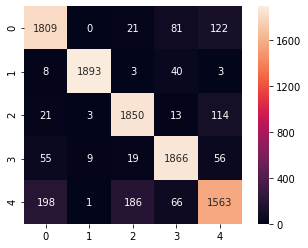

In [20]:
x_train, y_train = read_data("fashion_train.npy")
x_train = np.load("new_lda_4dim_train.npy").T
x_train = x_train * 100
x_test, y_test = read_data("fashion_test.npy")
x_test = np.load("new_lda_4dim_test.npy").T
x_test = x_test * 100

ss = load_model("SVM4")
ctrain = statistics(x_train, y_train, ss, "train set")

#plot_confusion_matrix(conf_mat_test)

simple test set accuracy  0.8132
794.0 3768.0 232.0 206.0
956.0 3975.0 25.0 44.0
835.0 3791.0 209.0 165.0
873.0 3837.0 163.0 127.0
608.0 3695.0 305.0 392.0
average test set accuracy 0.9252800000000001
precision  {0: 0.794, 1: 0.956, 2: 0.835, 3: 0.873, 4: 0.608}
recall  {0: 0.7738791423001949, 1: 0.9745158002038736, 2: 0.7998084291187739, 3: 0.8426640926640927, 4: 0.6659364731653888}
f1 scoretest set  0.8118439343453391


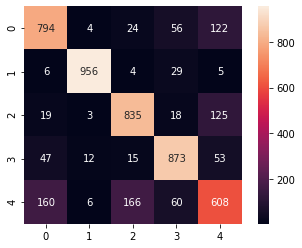

In [21]:
ctest = statistics(x_test, y_test, ss, "test set")

precision  0.898672320243057
recall  0.8985176652958599


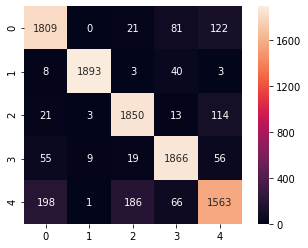

In [30]:
ax = sb.heatmap(np.intc(ctrain),  annot=True, fmt="d", cbar=True, square=True)
plt.savefig("svm_train_conf_mat.png")
prec = calc_precision(ctrain)
print("precision ", sum(prec.values())/5)
recall = calc_recall(ctrain)
print("recall ", sum(recall.values())/5)

precision  0.8131999999999999
recall  0.8113607874904648


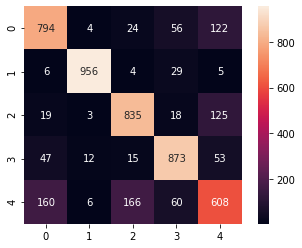

In [31]:
ax = sb.heatmap(np.intc(ctest),  annot=True, fmt="d", cbar=True, square=True)
plt.savefig("svm_test_conf_mat.png")
prec = calc_precision(ctest)
print("precision ", sum(prec.values())/5)
recall = calc_recall(ctest)
print("recall ", sum(recall.values())/5)